# 9.6 Lab: Support Vector Machines

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score,confusion_matrix,roc_curve, auc, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.metrics import classification_report, ConfusionMatrixDisplay

import json
%matplotlib inline
import seaborn as sns
sns.set_theme()
sns.set_style("ticks")

In [3]:
# support function to plot the decision boundary of svc and highlight the support vectors
def plot_decision_boundary(svc, X, y, h=0.021, pad=0.21):
    x_min, x_max = X[:, 0].min() - pad, X[:, 0].max() + pad
    y_min, y_max = X[:, 1].min() - pad, X[:, 1].max() + pad
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(10,8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.2)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)

    # highlight the support vectors
    sv = svc.support_vectors_
    plt.scatter(sv[:,0], sv[:,1], c='k', marker='*', s=21, linewidths=1)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()
    print('Number of support vectors: ', svc.support_.size)

## 9.6.1 Support Vector Classifier

The `scikit` library contains implementations for a number of statistical learning methods. In particular, the `SVC()` class can be used to fit a support vector classifier when the argument `kernel = 'linear'` is used.

This function uses a slightly different formulation from (9.14) and (9.25) for the support vector classifier.  

A `C` argument allows us to specify the cost of a violation to the margin.  When the `C` argument is small, then the margins will be wide and many support vectors will be on the margin or will violate the margin.  When the `C` argument is large, then the margins will be narrow and there will be few support vectors on the margin or violating the margin.

We now use the `SVC()` class to fit the support vector classifier for a given value of the `C` parameter. Here we demonstrate the use of this function on a two-dimensional example so that we can plot the resulting decision boundary. We begin by generating the observations, which belong to two classes, and checking whether the classes are linearly separable.

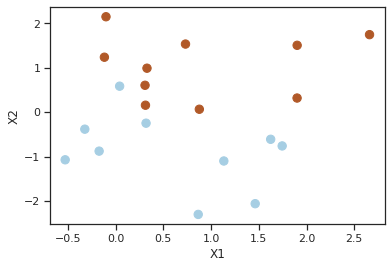

In [4]:
# we start from generating random dataset: following the bookm we generate a dataset with 20 observations,
# 2 features. And we divide these into two classes.
np.random.seed(1)
X = np.random.randn(20, 2)
y = np.repeat([-1,1], 10)
X[y==1] = X[y==1] + 1

plt.scatter(X[:,0], X[:,1], s=70, c=y, cmap=plt.cm.Paired)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

They are not. Next, we fit the support vector classifier. Note that `SVC()` performs classification (as opposed to SVM-based regression `SVR()`). We now create a data frame with the response coded as a factor.

The argument `C=10` tells the `SVC()` to set the cost to 10. We can now plot the support vector classifier obtained:

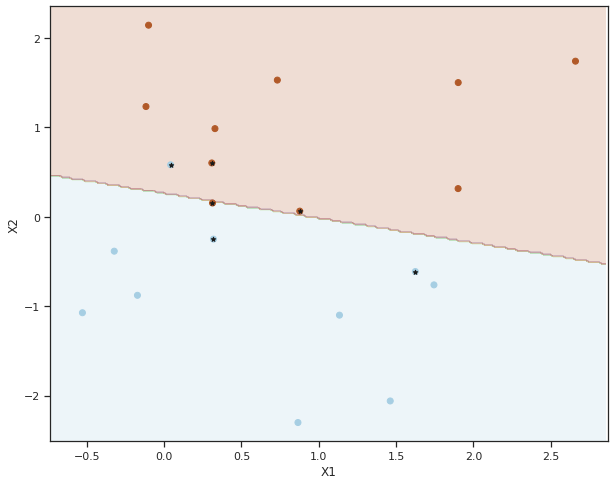

Number of support vectors:  6


In [5]:
# Support Vector Classifier (i.e. support vector machine with linear kernel)
svc1 = SVC(C=10, kernel='linear')
svc1.fit(X, y)

plot_decision_boundary(svc1, X, y)

Note that the three arguments to the SVM `plot_decision_boundary()` function are the output of the call to `SVC()`, as well as the data used in the call to `fit()`. The region of feature space that will be assigned to the $-1$ class is shown in light yellow, and the region that will be assigned to the $+1$ class is shown in red. The decision boundary between the two classes is linear (because we used the argument `kernel = 'linear'`), though due to the way in which the plotting function is implemented in this library the decision boundary looks somewhat jagged in the plot. 

The support vectors are plotted with a "*" and the remaining observations are plotted as circles; we see here that there are six support vectors. We can determine their identities as follows:

In [6]:
svc1.support_

array([ 0,  4,  9, 13, 15, 16], dtype=int32)

We can obtain some basic information about the support vector classifier fit using the `get_params()` command:

In [7]:
# we could take a look at the defaul parameters of the SVC model
svc1.get_params()

{'C': 10,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

What if we instead used a smaller value of the cost parameter?

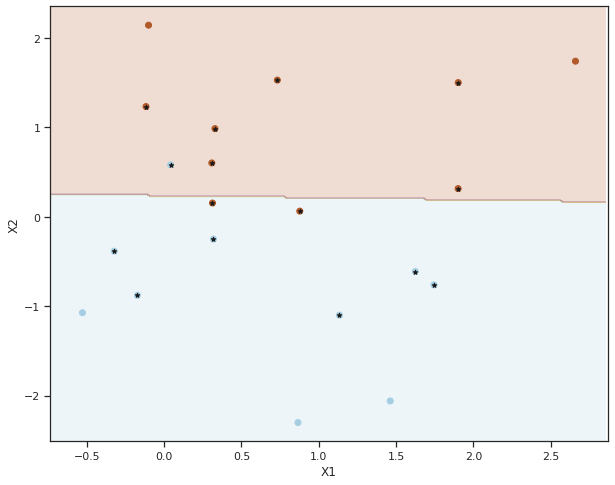

Number of support vectors:  15


In [8]:
# we use a small cost (c = 0.1). A smaller value of the cost parameter is being used, 
# we obtain a larger number of support vectors, because the margin is now wider. 
svc2 = SVC(C=0.1, kernel='linear')
svc2.fit(X, y)

plot_decision_boundary(svc2, X, y)


Now that a smaller value of the cost parameter is being used, we obtain a larger number of support vectors, because the margin is now wider. Unfortunately, the `SVC()` function does not explicitly output the coefficients of the linear decision boundary obtained when the support vector classifier is fit, nor does it output the width of the margin.

The `scikit` library includes a built-in function, `GridSearchCV()`, to perform cross-validation. By default, `GridSearchCV()` performs five-fold cross-validation `cv=5` on a set of models of interest. In order to use this function, we pass in relevant information about the set of models that are under consideration. The following command indicates that we want to compare SVMs with a linear kernel, using a range of values of the `C` parameter.

In [9]:
tuned_parameters = [{'C': [0.001, 0.01, 0.1, 1, 5, 10, 100]}]
clf = GridSearchCV(SVC(kernel='linear'), tuned_parameters, cv=10, scoring='accuracy', return_train_score=True)
clf.fit(X, y)

GridSearchCV(cv=10, estimator=SVC(kernel='linear'),
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 5, 10, 100]}],
             return_train_score=True, scoring='accuracy')

We can easily access the cross-validation errors for each of these models using the `cv_results_` in a pandas DataFrame:

In [10]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.000566,0.000205,0.000383,0.000128,0.001,{'C': 0.001},1.0,1.0,1.0,1.0,...,0.944444,0.944444,0.944444,0.944444,0.944444,0.944444,0.944444,1.000000,0.950000,0.016667
1,0.000472,0.000039,0.000317,0.000013,0.01,{'C': 0.01},1.0,1.0,1.0,1.0,...,0.944444,0.944444,0.944444,0.944444,0.944444,0.944444,0.944444,1.000000,0.950000,0.016667
2,0.000450,0.000019,0.000308,0.000007,0.1,{'C': 0.1},1.0,1.0,1.0,0.5,...,0.833333,0.888889,0.833333,0.833333,0.888889,0.833333,0.833333,0.888889,0.850000,0.025459
3,0.000499,0.000045,0.000346,0.000036,1,{'C': 1},1.0,1.0,1.0,1.0,...,0.833333,0.888889,0.944444,0.833333,0.888889,0.944444,0.944444,1.000000,0.916667,0.051220
4,0.000472,0.000031,0.000326,0.000041,5,{'C': 5},1.0,1.0,1.0,1.0,...,0.888889,0.888889,0.944444,0.833333,0.944444,0.888889,0.888889,1.000000,0.905556,0.043390
5,0.000438,0.000003,0.000307,0.000003,10,{'C': 10},1.0,1.0,1.0,1.0,...,0.888889,0.888889,0.944444,0.833333,0.944444,0.888889,0.888889,1.000000,0.905556,0.043390
6,0.000486,0.000027,0.000329,0.000021,100,{'C': 100},1.0,1.0,1.0,1.0,...,0.944444,0.888889,0.944444,0.944444,1.000000,0.944444,0.944444,1.000000,0.950000,0.029918


We see that  `cost = 0.001` results in the lowest cross-validation error rate. The `tune()` function stores the best model obtained, which can be accessed as follows:

In [11]:
# let us see the best parameters. 
# This is different from the results in the book, it is very likely due to the random generation of the datasetof the data
clf.best_params_

{'C': 0.001}

The `predict()` function can be used to predict the class label on a set of test observations, at any given value of the cost parameter. We begin by generating a
test data set.

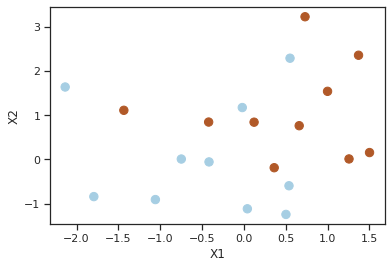

In [12]:
# we use the same generation process to generate test data
np.random.seed(2)
X_test = np.random.randn(20, 2)
y_test = np.repeat([-1,1], 10)
X_test[y_test==1] = X_test[y_test==1] + 1

plt.scatter(X_test[:,0], X_test[:,1], s=70, c=y_test, cmap=plt.cm.Paired)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

Now we predict the class labels of these test observations. Here we use the best model obtained through cross-validation in order to make predictions.

              precision    recall  f1-score   support

          -1       0.88      0.70      0.78        10
           1       0.75      0.90      0.82        10

    accuracy                           0.80        20
   macro avg       0.81      0.80      0.80        20
weighted avg       0.81      0.80      0.80        20



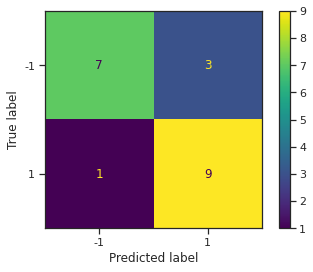

In [13]:
# train a model with the optimal parameters
svc3 = SVC(C=0.001, kernel='linear')
svc3.fit(X, y)

y_pred = svc3.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred);
print(classification_report(y_test, y_pred))

Thus, with this value of `C`, 16 of the test observations are correctly classified. What if we had instead used `cost = 0.01`?

In [14]:
#TODO: Exercise

Now consider a situation in which the two classes are linearly separable. Then we can find a separating hyperplane using the `SVC()` function. We first further separate the two classes in our simulated data so that they are linearly separable:

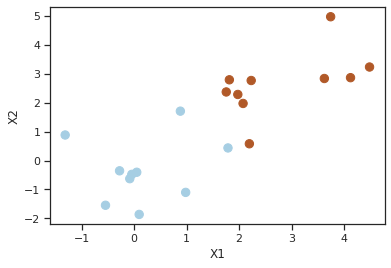

In [15]:
# now we make our data linear separable. In the book, they add another 0.5 to seperate the data. 
# here we start from the data generation process to avoid confusion.
np.random.seed(3)
X = np.random.randn(20, 2)
y = np.repeat([-1,1], 10)
X[y==1] = X[y==1] + 3.0

plt.scatter(X[:,0], X[:,1], s=70, c=y, cmap=plt.cm.Paired)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

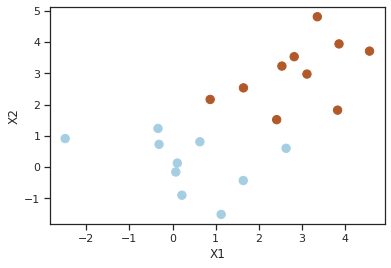

In [16]:
np.random.seed(6)
X_test = np.random.randn(20, 2)
y_test = np.repeat([-1,1], 10)
X_test[y_test==1] = X_test[y_test==1] + 3.0

plt.scatter(X_test[:,0], X_test[:,1], s=70, c=y_test, cmap=plt.cm.Paired)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

Now the observations are just barely linearly separable.
We fit the support vector classifier and plot the resulting hyperplane, using a very large value of `C` so that no observations are misclassified.

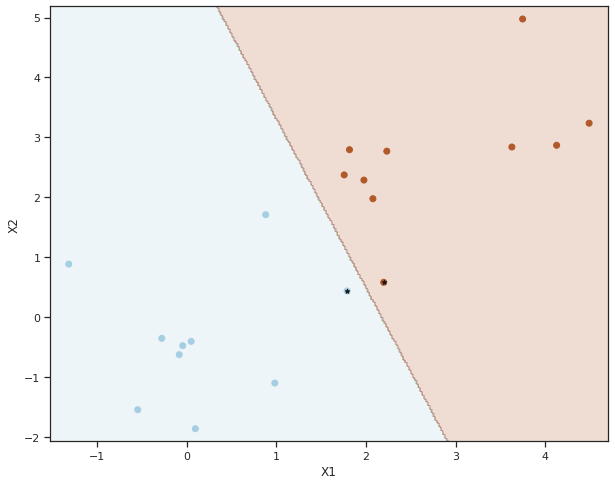

Number of support vectors:  2


In [17]:
# here seems the data is linear separable. We could use a bigger cost parameter (C = 100) to train the model.
svc4 = SVC(C=100, kernel='linear')
svc4.fit(X, y)

plot_decision_boundary(svc4, X, y)

              precision    recall  f1-score   support

          -1       0.90      0.90      0.90        10
           1       0.90      0.90      0.90        10

    accuracy                           0.90        20
   macro avg       0.90      0.90      0.90        20
weighted avg       0.90      0.90      0.90        20



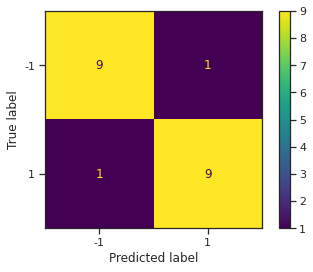

In [18]:
y_pred = svc4.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred);
print(classification_report(y_test, y_pred))

No training errors were made and only two support vectors were used. However, we can see from the figure that the margin is very narrow (because the observations that are not support vectors, indicated as circles, are very close to the decision boundary). It seems likely that this model will perform poorly on test data. We now try a smaller value of `C`:

In [19]:
#TODO: Exercise

Using `C=1`, we misclassify a training observation, but we also obtain a much wider margin and make use of seven support vectors. It seems likely that this model will perform better on test data than the model with  `C = 1e5`.

## 9.6.2 Support Vector Machine

In order to fit an SVM using a non-linear kernel, we once again use the `SCV()` class. However, now we use a different value of the parameter `kernel`. To fit an SVM with a polynomial kernel we use `kernel = 'poly'`, and to fit an SVC with a radial kernel   we use `kernel = 'rbf'`. In the former case we also use the `degree` argument to specify a degree for the polynomial kernel (this is $d$ in (9.22)), and in the latter case we use `gamma` to specify a value of $\gamma$ for the radial basis kernel (9.24). 

We first generate some data with a non-linear class boundary, as follows:

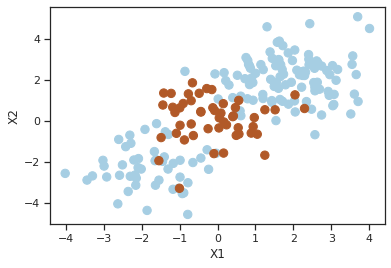

In [20]:
# generating random dataset
np.random.seed(21)
X = np.random.randn(200,2)
X[:100] = X[:100] + 2
X[101:150] = X[101:150] - 2
y = np.concatenate([np.repeat(-1, 150), np.repeat(1,50)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2)

plt.scatter(X[:,0], X[:,1], s=70, c=y, cmap=plt.cm.Paired)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

Plotting the data makes it clear that the class boundary is indeed non-linear:

In [21]:
# in python, we can use the same svc model abd kernel to specific the kernel
# for rbf kernel, we need to specify the gamma parameter
svm = SVC(C=1.0, kernel='rbf', gamma=1)
svm.fit(X_train, y_train)

SVC(gamma=1)

The data is randomly split into training and testing groups. We then fit the training data using the `SVC()` class with a radial kernel and $\gamma=1$:

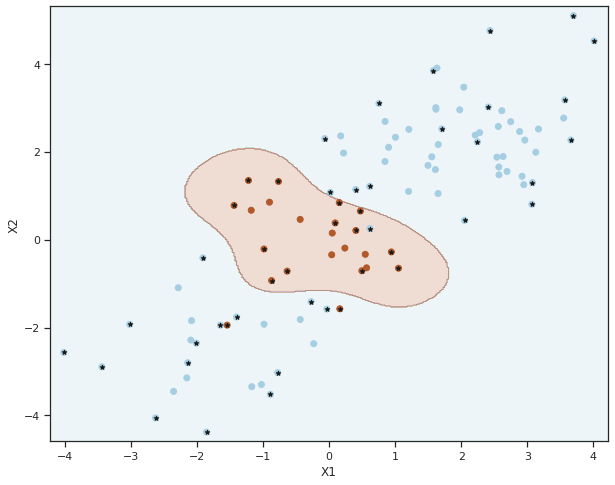

Number of support vectors:  47


In [22]:
plot_decision_boundary(svm, X_train, y_train)

The plot shows that the resulting  SVM has a decidedly non-linear  boundary. The `get_params()` function can be used to obtain some  information about the SVM fit:

In [23]:
svc1.get_params()

{'C': 10,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

              precision    recall  f1-score   support

          -1       0.85      0.96      0.90        73
           1       0.83      0.56      0.67        27

    accuracy                           0.85       100
   macro avg       0.84      0.76      0.78       100
weighted avg       0.85      0.85      0.84       100



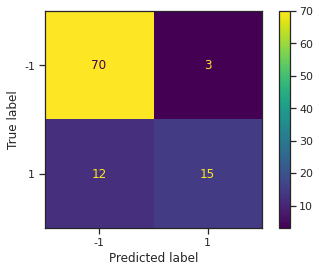

In [24]:
y_pred = svm.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred);
print(classification_report(y_test, y_pred))

We can see from the figure that there are a fair number of training errors in this SVM fit.

If we increase the value of `C`, we can reduce the number of training errors. However, this comes at the price of a more irregular decision boundary that seems to be at risk of overfitting the data.

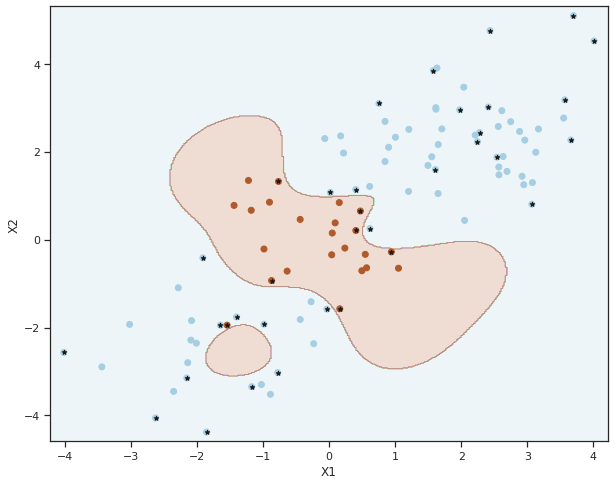

Number of support vectors:  35


In [25]:
# increasing C parameter which increases more flexibility
svm2 = SVC(C=100, kernel='rbf', gamma=1.0)
svm2.fit(X_train, y_train)
plot_decision_boundary(svm2, X_train, y_train)

              precision    recall  f1-score   support

          -1       0.83      0.86      0.85        73
           1       0.58      0.52      0.55        27

    accuracy                           0.77       100
   macro avg       0.71      0.69      0.70       100
weighted avg       0.76      0.77      0.77       100



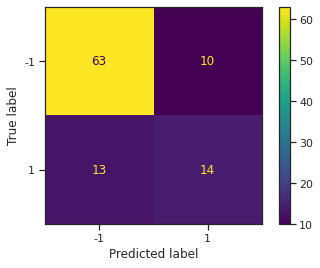

In [26]:
"""
The above decision boundary seems overfitting. We can compute the test accuracy of the model to
see whether that is the case. 

The model (c = 1) yields a test accuracy of 0.85; the model(c = 100) yields a test accuracy of 0.77.
"""
y_pred = svm2.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred);
print(classification_report(y_test, y_pred))

We can perform cross-validation using `GridSearchCV()` to select the best choice of $\gamma$ and `cost` for an SVM with a radial kernel:

In [27]:
# set the parameters by cross-validation
tuned_parameters = [{'C': [0.01, 0.1, 1, 10, 100],
                     'gamma': [0.5, 1,2,3,4]}]
clf = GridSearchCV(SVC(kernel='rbf'), tuned_parameters, cv=10, scoring='accuracy', return_train_score=True)
clf.fit(X_train, y_train)
pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.000815,0.000178,0.000415,0.000068,0.01,0.5,"{'C': 0.01, 'gamma': 0.5}",0.8,0.8,0.8,...,0.766667,0.766667,0.766667,0.766667,0.766667,0.777778,0.777778,0.777778,0.770000,0.005092
1,0.000758,0.000033,0.000374,0.000010,0.01,1,"{'C': 0.01, 'gamma': 1}",0.8,0.8,0.8,...,0.766667,0.766667,0.766667,0.766667,0.766667,0.777778,0.777778,0.777778,0.770000,0.005092
2,0.000812,0.000035,0.000385,0.000014,0.01,2,"{'C': 0.01, 'gamma': 2}",0.8,0.8,0.8,...,0.766667,0.766667,0.766667,0.766667,0.766667,0.777778,0.777778,0.777778,0.770000,0.005092
3,0.000900,0.000088,0.000393,0.000016,0.01,3,"{'C': 0.01, 'gamma': 3}",0.8,0.8,0.8,...,0.766667,0.766667,0.766667,0.766667,0.766667,0.777778,0.777778,0.777778,0.770000,0.005092
4,0.000885,0.000020,0.000387,0.000010,0.01,4,"{'C': 0.01, 'gamma': 4}",0.8,0.8,0.8,...,0.766667,0.766667,0.766667,0.766667,0.766667,0.777778,0.777778,0.777778,0.770000,0.005092
5,0.001036,0.000219,0.000563,0.000123,0.1,0.5,"{'C': 0.1, 'gamma': 0.5}",0.8,0.8,0.8,...,0.766667,0.766667,0.788889,0.800000,0.800000,0.811111,0.777778,0.777778,0.786667,0.014741
6,0.000982,0.000198,0.000443,0.000094,0.1,1,"{'C': 0.1, 'gamma': 1}",0.8,0.8,0.8,...,0.766667,0.766667,0.766667,0.766667,0.766667,0.777778,0.777778,0.777778,0.770000,0.005092
7,0.001072,0.000046,0.000441,0.000019,0.1,2,"{'C': 0.1, 'gamma': 2}",0.8,0.8,0.8,...,0.766667,0.766667,0.766667,0.766667,0.766667,0.777778,0.777778,0.777778,0.770000,0.005092
8,0.001140,0.000049,0.000436,0.000019,0.1,3,"{'C': 0.1, 'gamma': 3}",0.8,0.8,0.8,...,0.766667,0.766667,0.766667,0.766667,0.766667,0.777778,0.777778,0.777778,0.770000,0.005092
9,0.001122,0.000040,0.000427,0.000021,0.1,4,"{'C': 0.1, 'gamma': 4}",0.8,0.8,0.8,...,0.766667,0.766667,0.766667,0.766667,0.766667,0.777778,0.777778,0.777778,0.770000,0.005092


Therefore, the best choice of parameters involves `cost = 1` and `gamma = 0.5`.
We can view the test set predictions for this model by applying the `predict()` function to the data. Notice that to do this we subset the dataframe `dat` using `-train` as an index set.

In [28]:
# let us see the best parameters.
clf.best_params_

{'C': 1, 'gamma': 0.5}

              precision    recall  f1-score   support

          -1       0.86      0.95      0.90        73
           1       0.80      0.59      0.68        27

    accuracy                           0.85       100
   macro avg       0.83      0.77      0.79       100
weighted avg       0.85      0.85      0.84       100



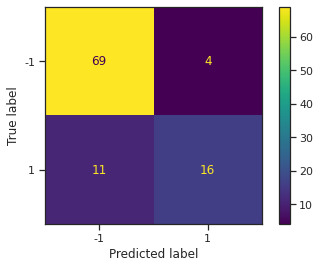

In [29]:
ConfusionMatrixDisplay.from_predictions(y_test, clf.best_estimator_.predict(X_test));
print(classification_report(y_test, clf.best_estimator_.predict(X_test)))

$15\,\%$ of test observations are misclassified by this SVM.

## 9.6.3 ROC Curves

The `scikit` package can be used to produce ROC curves such as those in Figures9.10 and 9.11. We first write a short function to plot an ROC curve given a vector containing a numerical score for each observation, `pred`, and a vector containing the class label for each observation, `truth`.

In [30]:
svm3 = SVC(C=1, kernel='rbf', gamma=2)
svm3.fit(X_train, y_train)

# we train another model flexible model
svm4 = SVC(C=1, kernel='rbf', gamma=50)
svm4.fit(X_train, y_train)

y_train_score3 = svm3.decision_function(X_train)
y_train_score4 = svm4.decision_function(X_train)

false_pos_rate3, true_pos_rate3, _ = roc_curve(y_train, y_train_score3)
roc_auc3 = auc(false_pos_rate3, true_pos_rate3)

false_pos_rate4, true_pos_rate4, _ = roc_curve(y_train, y_train_score4)
roc_auc4 = auc(false_pos_rate4, true_pos_rate4)

SVMs and support vector classifiers output class labels for each observation. However, it is also possible to obtain *fitted values* for each observation, which are the numerical scores used to obtain the class labels. For instance, in the case of a support vector classifier, the fitted value for an observation $X= (X_1, X_2, \ldots, X_p)^T$ takes the form $\hat{\beta}_0 + \hat{\beta}_1 X_1 + \hat{\beta}_2 X_2 + \cdots + \hat{\beta}_p X_p$. For an SVM with a non-linear kernel, the equation that yields the fitted value is given in (9.23). In essence, the sign of the fitted value determines on which side of the decision boundary the observation lies. Therefore, the relationship between the fitted value and the class prediction for a given observation is simple: if the fitted value exceeds zero then the observation is assigned to one class, and if it is less than zero then it is assigned to the other. In order to obtain the fitted values for a given SVM model fit, we use `decision_function()` after fitting `SVC()`, which will output the fitted values.

Now we can produce the ROC plot. Note we use the negative of the fitted values so that negative values correspond to class 1 and positive values to class 2.

SVM appears to be producing accurate predictions. By increasing $\gamma$ we can produce a more flexible fit and generate further improvements in accuracy.

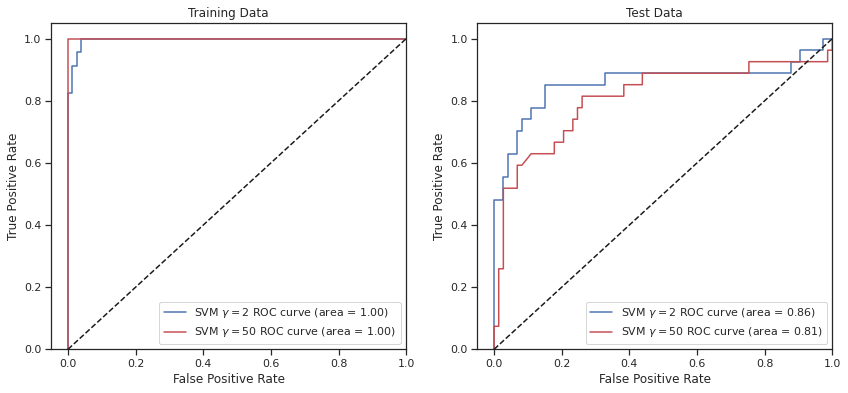

In [31]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14,6))
ax1.plot(false_pos_rate3, true_pos_rate3, label='SVM $\gamma = 2$ ROC curve (area = %0.2f)' % roc_auc3, color='b')
ax1.plot(false_pos_rate4, true_pos_rate4, label='SVM $\gamma = 50$ ROC curve (area = %0.2f)' % roc_auc4, color='r')
ax1.set_title('Training Data')

y_test_score3 = svm3.decision_function(X_test)
y_test_score4 = svm4.decision_function(X_test)

false_pos_rate3, true_pos_rate3, _ = roc_curve(y_test, y_test_score3)
roc_auc3 = auc(false_pos_rate3, true_pos_rate3)

false_pos_rate4, true_pos_rate4, _ = roc_curve(y_test, y_test_score4)
roc_auc4 = auc(false_pos_rate4, true_pos_rate4)

ax2.plot(false_pos_rate3, true_pos_rate3, label='SVM $\gamma = 2$ ROC curve (area = %0.2f)' % roc_auc3, color='b')
ax2.plot(false_pos_rate4, true_pos_rate4, label='SVM $\gamma = 50$ ROC curve (area = %0.2f)' % roc_auc4, color='r')
ax2.set_title('Test Data')

for ax in fig.axes:
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")

However, the ROC curves on the left are all on the training data. We are really more interested in the level of prediction accuracy on the test data. When we compute the ROC curves on the test data, the model with $\gamma=2$ appears to provide the most accurate results.

## 9.6.4 SVM with Multiple Classes

If the response is a factor containing more than two levels, then the `SVC()` class will perform multi-class classification using the one-versus-one approach. We explore that setting here by generating a third class of observations.

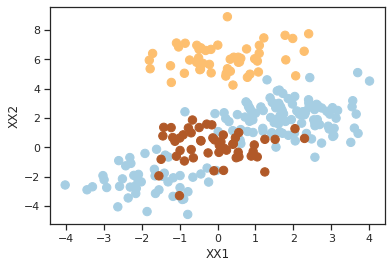

In [32]:
# generate the previously used random dataset
np.random.seed(21)
X = np.random.randn(200,2)
X[:100] = X[:100] + 2
X[101:150] = X[101:150] - 2
y = np.concatenate([np.repeat(-1, 150), np.repeat(1,50)])

# adding another class to the dataset, I used a different offset to separate the classes better
XX = np.vstack([X, np.random.randn(50,2)])
yy = np.hstack([y, np.repeat(0,50)])
XX[yy==0, 1] = XX[yy==0, 1] + 6

plt.scatter(XX[:,0], XX[:,1], s=70, c=yy, cmap=plt.cm.Paired)
plt.xlabel('XX1')
plt.ylabel('XX2');

We now fit an SVM to the data:

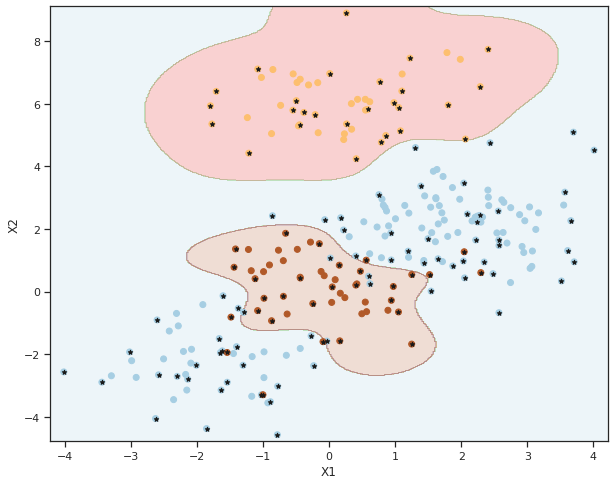

Number of support vectors:  123


In [33]:
# fit the svm model 
svm5 = SVC(C=10, kernel='rbf', gamma=1)
svm5.fit(XX, yy)
plot_decision_boundary(svm5, XX, yy)

The `scikit learn` library can also be used to perform support vector regression, if the response vector that is passed in to `SVR()` is numerical rather than a factor.

## 9.6.5 Application to Gene Expression Data

We now examine the `Khan` data set, which  consists of a number of tissue samples corresponding to four distinct types of small
round blue cell tumors. For each tissue sample, gene expression measurements are available.
The data set consists of training data, `xtrain` and `ytrain`, and testing data, `xtest` and `ytest`.

In [34]:
# I saved the gene expression data as a json file, in python we could load the json file using the json library
# after reading in the data, we can use the data is same as a dictionary, we can use the keys to access the data
# import json
!wget https://raw.githubusercontent.com/tvanzyl/Sharing_ISL_python/master/data/Khan.json -N
f = open('Khan.json',)
Khan = json.load(f)
print(Khan.keys())

--2022-11-07 13:27:33--  https://raw.githubusercontent.com/tvanzyl/Sharing_ISL_python/master/data/Khan.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1783318 (1.7M) [text/plain]
Saving to: ‘Khan.json’

Khan.json           100%[===================>]   1.70M  --.-KB/s    in 0.01s   

Last-modified header missing -- time-stamps turned off.
2022-11-07 13:27:34 (157 MB/s) - ‘Khan.json’ saved [1783318/1783318]

dict_keys(['xtrain', 'xtest', 'ytrain', 'ytest'])


We examine the dimension of the data:

In [35]:
X_train = np.array(Khan['xtrain'])
y_train = np.array(Khan['ytrain'])
X_test = np.array(Khan['xtest'])
y_test = np.array(Khan['ytest'])

This data set consists of expression measurements for $2{,}308$  genes.  The training and test sets consist of $63$ and $20$ observations respectively.

In [36]:
X_train.shape, X_test.shape

((63, 2308), (20, 2308))

In [37]:
# take a look at the data, we will notice there are 4 classes
np.unique(y_train)

array([1, 2, 3, 4])

We will use a support vector approach to predict cancer subtype using gene expression measurements.
In this data set, there are a very large number of  features relative to the number of observations. This suggests that we should use a  linear kernel, because the additional flexibility that will
result from using a polynomial or radial kernel is unnecessary. 


In [42]:
svm6 = SVC(C = 10, kernel='linear')
svm6.fit(X_train, y_train)
print('train accuracy', svm6.score(X_train, y_train))

train accuracy 1.0


We  see that there are *no* training errors. In fact, this is not surprising, because
the large number of variables relative to the number of observations implies that it is easy to find hyperplanes that fully separate the classes. We are most interested not in the support vector classifier's performance on the training observations, but rather its performance on the test observations.

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         3
           2       0.75      1.00      0.86         6
           3       1.00      0.67      0.80         6
           4       1.00      1.00      1.00         5

    accuracy                           0.90        20
   macro avg       0.94      0.92      0.91        20
weighted avg       0.93      0.90      0.90        20



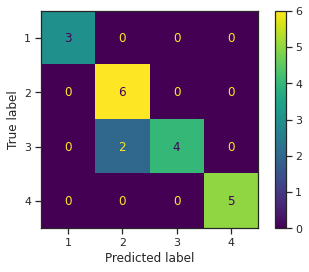

In [43]:
y_pred = svm6.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred);
print(classification_report(y_test, y_pred))


We see that using `C=10` yields two test set errors on this
data.

In [40]:
# End of Chapter 9